<a href="https://colab.research.google.com/github/sriharisivashanmugam/BlowerFault/blob/main/Blower_Fault_v2_3_Jan_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

For every heater, regardless of period of data available, do feature engineering, normalize them temporally by period of data available and have 2 clusters faulty/non-fauly, analyze the two clusters for significant differences and try predicting new heaters in the clusters.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os

In [57]:
def had_fault(data):
  if 'E1.0' in set(data['ErrorCode']):
    return True
  else:
    return False

def number_of_unique_faults(data):
  data['lag_error'] = data['ErrorCode'].shift(1)
  return data[(data['ErrorCode']=='E1.0') & (data['lag_error']!='E1.0')].shape[0]

def get_stats(data):
  if had_fault(data)==True:
    data['lag'] = data['ErrorCode'].shift(1)
    end = int(data[(data['ErrorCode']=='E1.0') & (data['lag']!='E1.0')].index[0])
    data = data.iloc[0:end+1,:]
  mean_pwm = data['BlowerPWM'].mean()
  mean_rpm = data['BlowerRPM'].mean()
  mean_fr = data['FiringRate'].mean()
  mean_ft = data['FlueTemperature'].mean()
  max_pwm = data['BlowerPWM'].max()
  max_rpm = data['BlowerRPM'].max()
  max_fr = data['FiringRate'].max()
  max_ft = data['FlueTemperature'].max()
  std_pwm = data['BlowerPWM'].std()
  std_rpm = data['BlowerRPM'].std()

  return mean_pwm,mean_rpm,mean_fr,mean_ft,max_pwm,max_rpm,max_fr,max_ft,std_pwm,std_rpm

def get_agg(data):
  pass

def prepare_data_frame(path):
  di = {'HEX':[],'mean_pwm':[],'mean_rpm':[],'mean_fr':[],'max_pwm':[],'max_rpm':[],'max_fr':[],'had_fault':[]}
  for i in os.listdir(path):
    temp = pd.read_csv(path+i)
    di['HEX'].append(i.split('.')[0])
    res = get_stats(temp)
    di['mean_pwm'].append(res[0])
    di['mean_rpm'].append(res[1])
    di['mean_fr'].append(res[2])
    # di['mean_ft'].append(res[3])
    di['max_pwm'].append(res[4])
    di['max_rpm'].append(res[5])
    di['max_fr'].append(res[6])
    # di['max_ft'].append(res[7])
    di['had_fault'].append(had_fault(temp))
  df = pd.DataFrame(di)
  return df

In [58]:
new_df = prepare_data_frame('/content/drive/MyDrive/Predictive Models/Blower Fault Phase 2/Hex_with_blowerFault-training/Hex_with_blowerFault/')

In [59]:
new_df = new_df[new_df['max_rpm']>0]

In [60]:
new_df.describe()

,mean_pwm,mean_rpm,mean_fr,max_pwm,max_rpm,max_fr
count,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000
mean,230.640365,6206.135789,15.050409,356.153846,8476.769231,197.333333
std,59.133195,1071.456876,11.485131,30.357986,368.423916,65.698808
min,113.595178,4118.827813,0.000000,293.000000,7597.000000,0.000000
25%,189.194474,5483.285174,5.940104,345.500000,8333.500000,155.000000
50%,237.119023,6162.978292,15.471253,353.000000,8366.000000,234.000000
75%,272.967454,7144.616034,20.676717,364.500000,8624.000000,251.000000
max,316.604897,7788.624666,51.747328,450.000000,9425.000000,251.000000


In [61]:
# pip install pycaret

In [62]:
from pycaret.classification import *
s = setup(new_df, target = 'had_fault', session_id = 123)

,Description,Value
0,Session id,123
1,Target,had_fault
2,Target type,Binary
3,Original data shape,"(39, 8)"
4,Transformed data shape,"(39, 8)"
5,Transformed train set shape,"(27, 8)"
6,Transformed test set shape,"(12, 8)"
7,Numeric features,6
8,Categorical features,1
9,Preprocess,True


In [63]:
best = compare_models(sort='Recall')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7000,0.6500,0.6000,0.5000,0.5333,0.3000,0.3000,0.5960
knn,K Neighbors Classifier,0.6833,0.6750,0.5000,0.4000,0.4333,0.2500,0.2500,0.0800
ridge,Ridge Classifier,0.7500,0.0000,0.5000,0.4500,0.4667,0.3500,0.3500,0.1120
et,Extra Trees Classifier,0.7667,0.5500,0.5000,0.4500,0.4667,0.4000,0.4000,0.2010
nb,Naive Bayes,0.7000,0.5500,0.3000,0.2500,0.2667,0.2000,0.2000,0.0640
svm,SVM - Linear Kernel,0.6167,0.0000,0.2000,0.1000,0.1333,0.0400,0.0500,0.1010
dt,Decision Tree Classifier,0.6167,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1100
rf,Random Forest Classifier,0.6167,0.6000,0.0000,0.0000,0.0000,0.0000,0.0000,0.3440
qda,Quadratic Discriminant Analysis,0.6167,0.3500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0670
ada,Ada Boost Classifier,0.6167,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0670


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [64]:
lr = create_model('lr')
lr = tune_model(lr)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.3333,0.0000,0.0000,0.0000,0.0000,-0.5000,-0.5000
1,0.6667,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,0.6667,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.3333,0.0000,0.0000,0.0000,0.0000,-0.5000,-0.5000
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,0.5000,1.0000,1.0000,0.5000,0.6667,0.0000,0.0000


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.3333,0.0000,0.0000,0.0000,0.0000,-0.5000,-0.5000
1,0.6667,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,0.6667,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.3333,0.0000,0.0000,0.0000,0.0000,-0.5000,-0.5000
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,0.5000,1.0000,1.0000,0.5000,0.6667,0.0000,0.0000


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


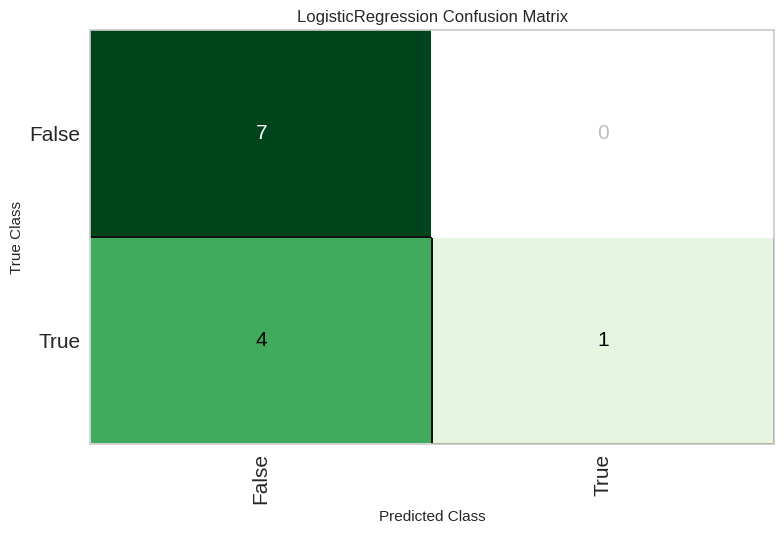

In [66]:
plot_model(best, plot = 'confusion_matrix')

Testing the model

In [31]:
test_df = prepare_data_frame('/content/drive/MyDrive/Predictive Models/Blower Fault Phase 2/Hex_with_blowerFault/')

In [32]:
test_df = test_df[~test_df['HEX'].isin(new_df['HEX'])]

In [33]:
test_df.dropna(inplace=True)

In [34]:
predictions = predict_model(best, data=test_df)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.4878,0.4547,0.4375,0.3684,0.4000,-0.0411,-0.0416


In [35]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(predictions['had_fault'],predictions['prediction_label']))

[[26 24]
 [18 14]]
